# WNBA Assist Networks

Assists allow for the exploration of visualizing data in a network. Networks consist of nodes (players) and edges (assists) connecting the nodes. An assist can be thought of as a pair of two players with the assist traveling from the assisting player to the scorer, just as two nodes are connected by an edge. If a player has multiple assists to another player, the edge in the assist network can be weighted to represent the greater volume.

The following explores the `Shots` and `League` classes of the [py_ball](https://github.com/basketballrelativity/py_ball) package by exploring the `pbp` and `commonallplayers` endpoints of the [stats.nba.com](https://stats.nba.com). The goal of this analysis is to build assist networks that communicate meaningful insights.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time

from py_ball import wnba_shots, league

HEADERS = {'Connection': 'close',
           'Host': 'stats.nba.com',
           'Origin': 'http://stats.nba.com',
           'Upgrade-Insecure-Requests': '1',
           'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_2)' + \
                         'AppleWebKit/537.36 (KHTML, like Gecko) ' + \
                         'Chrome/66.0.3359.117 Safari/537.36'}

ID_TO_TEAM_WNBA = {1611661330: 'Dream', 1611661321: 'Wings',
                   1611661320: 'Sparks', 1611661317: 'Mercury',
                   1611661329: 'Sky', 1611661325: 'Fever',
                   1611661324: 'Lynx', 1611661328: 'Storm',
                   1611661323: 'Sun', 1611661319: 'Aces',
                   1611661313: 'Liberty', 1611661322: 'Mystics'}

pd.options.mode.chained_assignment = None  # Disabling pandas SetWithCopyWarnings

The `Shots` class requires a few parameters:
- season: YYYY season year format
- game_id: The unique identifier for the game of interest

The following pulls play-by-play data for a 2019 season game between the Liberty and the Fever.

In [2]:
game_id = '1021900012'
season = '2019'

assists = wnba_shots.Shots(headers=HEADERS,
                           game_id=game_id,
                           season=season)
assist_df = pd.DataFrame(assists.data)
assist_df.head(15)

,cl,de,epid,etype,evt,hs,locX,locY,mtype,oftid,opid,opt1,opt2,ord,pid,tid,vs
0,10:00,Start Period,,12,2,0,0,-80,0,0,,0,0,20000,0,0,0
1,09:57,Jump Ball Dupree vs Charles (Laney gains posse...,204335,10,4,0,0,-80,0,1611661325,202250,0,0,60000,200676,1611661325,0
2,09:40,[IND 2-0] Dupree Fadeaway Jump Shot: Made (2 P...,203831,1,7,2,-67,101,63,1611661325,,2,0,70000,200676,1611661325,0
3,09:23,[NYL] Charles Jump Shot: Missed,,2,8,2,-117,30,1,1611661313,,2,0,80000,202250,1611661313,0
4,09:19,[NYL] Boyd Rebound (Off:1 Def:0),,4,9,2,-117,30,0,1611661313,,1,0,90000,204327,1611661313,0
5,09:18,[NYL] Charles Layup Shot: Missed,,2,10,2,9,20,5,1611661313,,2,0,100000,202250,1611661313,0
6,09:18,[IND] Team Rebound,,4,11,2,9,20,0,1611661313,,0,0,110000,0,1611661325,0
7,09:18,Stoppage: Out-of-Bounds,,20,12,2,0,-80,3,1611661325,,0,0,120000,0,0,0
8,09:05,[IND] Wheeler Turnover : Bad Pass (1 TO) Steal...,,5,13,2,-59,189,1,1611661325,204327,1,0,130000,204365,1611661325,0
9,08:58,[NYL] Boyd Layup Shot: Missed,,2,15,2,37,24,5,1611661313,,2,0,150000,204327,1611661313,0


Because players are identified by their player ID number in the play-by-play data, player metadata is needed so as to identify players by name in the assist network.

In [3]:
league_id = '10'

players = league.League(headers=HEADERS,
                        endpoint='commonallplayers',
                        league_id=league_id,
                        season=season)
player_df = pd.DataFrame(players.data['CommonAllPlayers'])
player_df.head(15)

,DISPLAY_FIRST_LAST,DISPLAY_LAST_COMMA_FIRST,FROM_YEAR,GAMES_PLAYED_FLAG,IS_NBA_ASSIGNED,NBA_ASSIGNED_TEAM_ID,PERSON_ID,PLAYERCODE,ROSTERSTATUS,TEAM_ABBREVIATION,TEAM_CITY,TEAM_CODE,TEAM_ID,TEAM_NAME,TO_YEAR
0,Natalie Achonwa,"Achonwa, Natalie",2015,Y,0,0,203831,natalie_achonwa,1,IND,Indiana,fever,1611661325,Fever,2019
1,Rebecca Allen,"Allen, Rebecca",2015,Y,0,0,204296,rebecca_allen,1,NYL,New York,liberty,1611661313,Liberty,2019
2,Kristine Anigwe,"Anigwe, Kristine",2019,Y,0,0,1629485,kristine_anigwe,1,CON,Connecticut,sun,1611661323,Sun,2019
3,Ariel Atkins,"Atkins, Ariel",2018,Y,0,0,1628878,ariel_atkins,1,WAS,Washington,mystics,1611661322,Mystics,2019
4,Seimone Augustus,"Augustus, Seimone",2006,Y,0,0,200671,seimone_augustus,1,MIN,Minnesota,lynx,1611661324,Lynx,2019
5,Rachel Banham,"Banham, Rachel",2016,Y,0,0,1627671,rachel_banham,1,CON,Connecticut,sun,1611661323,Sun,2019
6,Alana Beard,"Beard, Alana",2004,Y,0,0,100949,alana_beard,1,LAS,Los Angeles,sparks,1611661320,Sparks,2019
7,Alex Bentley,"Bentley, Alex",2013,Y,0,0,203410,alex_bentley,1,ATL,Atlanta,dream,1611661330,Dream,2019
8,Tiffany Bias,"Bias, Tiffany",2014,Y,0,0,203839,tiffany_bias,1,NYL,New York,liberty,1611661313,Liberty,2019
9,Monique Billings,"Billings, Monique",2018,Y,0,0,1628881,monique_billings,1,ATL,Atlanta,dream,1611661330,Dream,2019


Let's isolate all of the assists to view the data:

In [4]:
assist_df[(assist_df['epid']!='') & (assist_df['etype']==1)]

,cl,de,epid,etype,evt,hs,locX,locY,mtype,oftid,opid,opt1,opt2,ord,pid,tid,vs
2,09:40,[IND 2-0] Dupree Fadeaway Jump Shot: Made (2 P...,203831,1,7,2,-67,101,63,1611661325,,2,0,70000,200676,1611661325,0
11,08:49,[IND 5-0] Mitchell 3pt Shot: Made (3 PTS) Assi...,200676,1,17,5,-226,40,1,1611661325,,3,1,170000,1628909,1611661325,0
16,08:13,[IND 7-0] Laney Layup Shot: Made (2 PTS) Assis...,203831,1,23,7,-24,29,5,1611661325,,2,0,230000,204335,1611661325,0
22,07:30,[IND 11-0] Laney Running Layup Shot: Made (4 P...,204365,1,30,11,-17,13,41,1611661325,,2,1,300000,204335,1611661325,0
76,03:29,[NYL 7-15] Durr Jump Shot: Made (2 PTS) Assist...,204296,1,101,15,171,54,1,1611661313,,2,0,990000,1629476,1611661313,7
77,03:14,[IND 17-7] Mitchell Driving Layup Shot: Made (...,1628909,1,102,17,-13,29,6,1611661325,,2,0,1000000,1627676,1611661325,7
118,09:45,[NYL 9-26] Charles Layup Shot: Made (7 PTS) As...,204327,1,166,26,25,11,5,1611661313,,2,0,1620000,202250,1611661313,9
121,09:17,[NYL 12-26] Nurse 3pt Shot: Made (3 PTS) Assis...,204327,1,171,26,221,105,1,1611661313,,3,1,1660000,1628915,1611661313,12
122,09:03,[IND 28-12] McCowan Layup Shot: Made (2 PTS) A...,1627676,1,173,28,25,17,5,1611661325,,2,0,1680000,1629479,1611661325,12
130,08:03,[NYL 16-30] Nurse Pullup Jump shot: Made (6 PT...,204327,1,183,30,-32,118,79,1611661313,,2,0,1780000,1628915,1611661313,16


To create a network, we need to establish both nodes and edges. Each edge goes from a source node (assisting player) to a target node. The `network_data` function below also establishes coordinates for each node, along with the number of assists for each player. 

In [5]:
def network_data(pbp_df, team_id):
    """ network_dict creates nodes and edges
    for an assist network, along with information
    needed to plot the network

    @param pbp_df (DataFrame): DataFrame of play-by-play
        data with timeouts removed. Timeouts cause complications
        with getting players from the 'epid' field

    @param team_id (int): Unique team identifier

    Returns

        unique_players (list): List of player ID numbers
            corresponding to players on the team given

        edges (list): List of tuples in the form
            (assisting player ID, scoring player ID, number of assists)

        pos_dict (dict): Dictionary with keys of player ID numbers
            with (x, y) values corresponding to node coordinates

        weights (dict): Dictionary with keys of player ID numbers
            with assists as values
    """

    # First, let's identify all players on the team provided
    network = {}
    team_df = pbp_df[pbp_df['tid'] == team_id]
    unique_players = list(set(list(team_df['pid']) + list(team_df['epid'])))
    unique_players.remove('')
    unique_players.remove(0)
    unique_players = list(set([int(x) for x in unique_players]))

    # Next, we'll isolate the assists and loop through all unique assist
    # partners (assisting player, scorer)
    assist_df = team_df[(team_df['epid']!='') & (team_df['etype']==1)]
    network['links'] = {}
    count = 0
    all_assists = zip(assist_df['epid'], assist_df['pid'])
    all_assists = [(int(x), int(y)) for x, y in all_assists]
    unique_assists = list(set(all_assists))
    weights = {}
    for source, target in unique_assists:
        network['links'][count] = {}
        network['links'][count]['source'] = source
        network['links'][count]['target'] = target
        network['links'][count]['weight'] = sum([1 if x == (source, target) else 0 for x in all_assists])
        weights[(source, target)] = network['links'][count]['weight']
        count += 1

    links = len(network['links'])
    edges = [(network['links'][k]['source'],
              network['links'][k]['target'],
              network['links'][k]['weight']) for k in range(links)]

    # Finally, we'll get coordinates for all players in the assist
    # network around the unit circle
    angles = np.linspace(0, 360 - 360/float(len(unique_players)), len(unique_players))
    pos_dict = {}
    for angle, player in zip(angles, unique_players):
        pos_dict[player] = (np.cos(np.deg2rad(angle)), np.sin(np.deg2rad(angle)))

    return unique_players, edges, pos_dict, weights

In [6]:
team_id = 1611661325
nodes, edges, positions, weights = network_data(assist_df[assist_df['etype']!=9], team_id)

In [7]:
def plot_network(nodes, edges, positions, weights, players, team):
    """ plot_network plots the assist network given the
    data from the network_data function.

    @param nodes (list): List of player ID numbers
        corresponding to players on the team given

    @param edges (list): List of tuples in the form
        (assisting player ID, scoring player ID, number of assists)

    @param positions (dict): Dictionary with keys of player ID numbers
         with (x, y) values corresponding to node coordinates

    @param weights (dict): Dictionary with keys of player ID numbers
        with assists as values

    @param players (DataFrame): DataFrame of player metadata including
        the fields PERSON_ID and DISPLAY_FIRST_LAST

    @param team_id (int): Unique team identifier

    Returns

        fig (maplotlib.figure.Figure): Assist network visual
    """

    fig = plt.figure(figsize=(9, 9))
    axis = fig.add_subplot(111, aspect='auto')
    plt.title(ID_TO_TEAM_WNBA[team] + ' Assist Network', fontsize=18)

    # First, let's plot each node, labeling each with player name and
    # number of assists. The number of assists also control the markersize
    # of the nodes. Because of this and varying name lengths, the name
    # position is perturbed to ensure proper formatting
    for pos in positions:
        assists = sum([weights[x] if x[0] == pos else 0 for x in weights])
        plt.plot(positions[pos][0], positions[pos][1], marker='o',
                 markersize=(1 + assists)*5, markeredgecolor='k', fillstyle='none')
        name = players[players['PERSON_ID']==pos]['DISPLAY_FIRST_LAST'].iloc[0] + ' (' + str(int(assists)) + ')'
        if positions[pos][1] == 1:
            vertical_perturb = 0.005*(1 + assists)*5
        elif positions[pos][1] == -1:
            vertical_perturb = -0.005*(1 + assists)*5 - 0.05
        else:
            vertical_perturb = 0

        if positions[pos][0] < 0 and abs(positions[pos][1]) != 1:
            horiz_perturb = -0.03*len(name) - 0.0025*(1 + assists)*5
        elif positions[pos][0] >= 0 and abs(positions[pos][1]) != 1:
            horiz_perturb = 0.0025*len(name) + 0.0025*(1 + assists)*5
        else:
            horiz_perturb = -0.0175*len(name)
            
        plt.text(positions[pos][0] + horiz_perturb, positions[pos][1] + vertical_perturb,
                 name, fontsize=12)

    # Next, the edges are plotted as arrows with the arrow going from 
    # the assisting player to the scoring player. The size of the arrow
    # is a function of the number of assists for that directed pair.
    # Also, the transparency is set to 0.5 to account for instances
    # when a pair of players have assists to each other.
    for edge in edges:
        node1 = edge[0]
        node2 = edge[1]
        assists = edge[2]

        start_x = positions[node1][0]
        start_y = positions[node1][1]

        delta_x = positions[node2][0] - start_x
        delta_y = positions[node2][1] - start_y

        plt.arrow(start_x, start_y, delta_x, delta_y, width=0.01*assists,
                  length_includes_head=True, alpha=0.5)

    plt.ylim(-1.1, 1.1)
    plt.xlim(-1.1, 1.1)
    axis.set_aspect(1.0)
    plt.axis('off')
    plt.close()

    return fig

In [8]:
network = plot_network(nodes, edges, positions, weights, player_df, team_id)

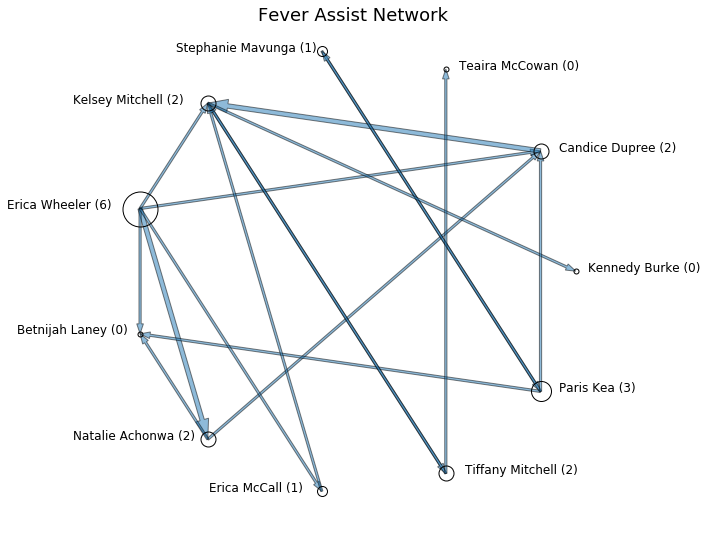

In [9]:
network

The assist network communicates a lot of information in a compact form:
    - Erica Wheeler led the team with six assists and distributed them to five different teammates
    - Each player either had an assist or scored an assisted basket
    - Kelsey Mitchell was the beneficiary of five assists
    - The greatest number of assists from one player to another is two
    - Two pairs had assists to each other: Tiffany Mitchell and Kelsey Mitchell, along with Paris Kea and Stephanie Mavunga.
    
## Exploration

    - What else can you add or change about the above assist network to enhance the visualization?
    - What other events in basketball could be visualized by a network?